# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`.
El número de pedidos está en la columna `num_orders`.

## Preparación

In [ ]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Cargamos los datos
data = pd.read_csv("/datasets/taxi.csv", parse_dates=[0], index_col=[0])

In [ ]:
# Revisamos la tabla
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
# Revisamos información general
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
# Revisamos distribución
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


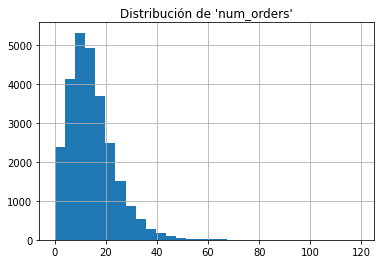

<Figure size 720x648 with 0 Axes>

In [ ]:
# Graficamos distribución
data["num_orders"].hist(bins=30)
plt.title("Distribución de 'num_orders'")
plt.figure(figsize=(10, 9))
plt.show()

In [ ]:
# Revisamos nan
data.isnull().sum()

num_orders    0
dtype: int64

In [ ]:
# Revisamos duplicados
data.duplicated().sum()

26415

In [ ]:
# Hacemos el remuestreo por hora
data_resampled = data.resample("1H").mean()
data_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,20.666667
2018-03-01 01:00:00,14.166667
2018-03-01 02:00:00,11.833333
2018-03-01 03:00:00,11.000000
2018-03-01 04:00:00,7.166667


La tabla es bastante sencilla. No tiene valores ausentes ni duplicados y los formatos de las columnas están en orden. Además, la distribución de los datos está correcta.

## Análisis

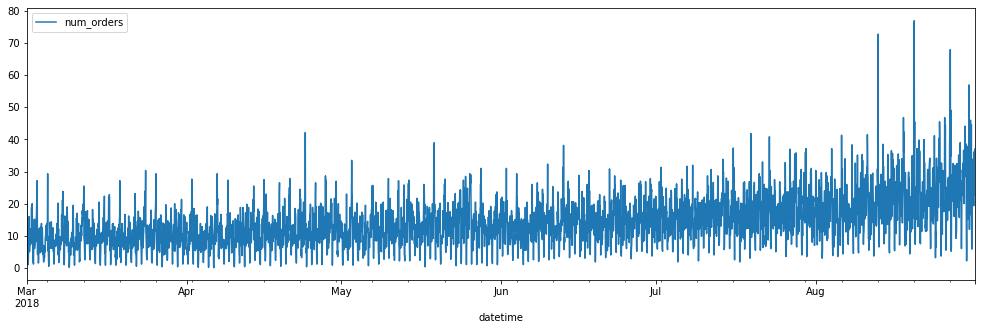

In [ ]:
# Graficamos nuestro muestreo por hora
data_resampled.plot(figsize=(17, 5))
plt.show()

- Aquí podemos ver que tenemos datos desde marzo hasta agosto.
- Además se puede observar un aumento paulatino de pedidos de taxis a través de los meses, es decir, hay una tendencia. Esto se ve más claro en el mes de agosto.

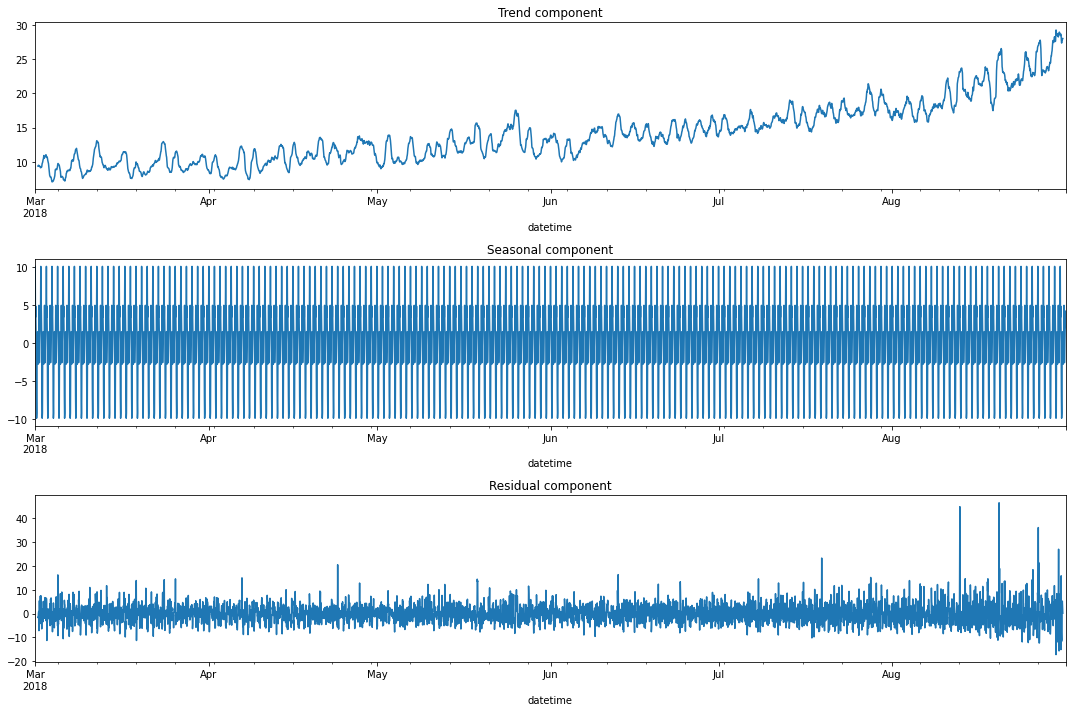

In [ ]:
# Aplicamos seasonal_decompose

decomposed_series = seasonal_decompose(data_resampled, period=24)


plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed_series.trend.plot(ax=plt.gca())
plt.title("Trend component")

plt.subplot(312)
decomposed_series.seasonal.plot(ax=plt.gca())
plt.title("Seasonal component")

plt.subplot(313)
decomposed_series.resid.plot(ax=plt.gca())
plt.title("Residual component")

plt.tight_layout()

- 1. En el componente de tendencia se ve de forma más clara la (valga la redundancia) tendencia que mencionamos anteriormente.
- 2. El componente estacional como es de esperar nos muestra un patrón repetitivo aunque tal vez en este caso sea complicado de interpretar debido a la naturaleza de los datos.

Ahora revisaremos los comportamientos con las medias móviles para periodos diarios, semanales y mensuales.

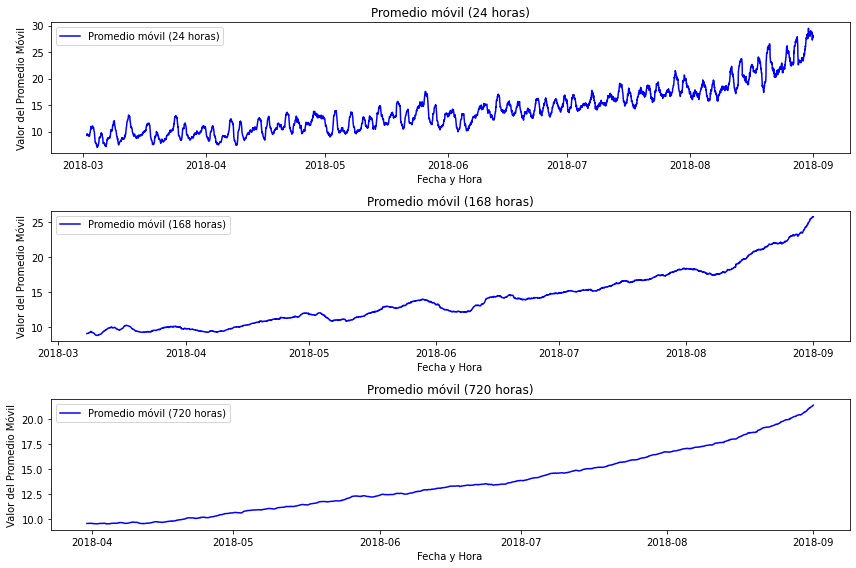

In [ ]:
# Graficamos los la media móvil por periodo

periodos = [24, 7*24, 30*24]

fig, axs = plt.subplots(len(periodos), figsize=(12, 8))

for i, periodo in enumerate(periodos):
    rolling_mean = data_resampled["num_orders"].rolling(window=periodo).mean()
    axs[i].plot(data_resampled.index, rolling_mean, label=f"Promedio móvil ({periodo} horas)", color='blue')
    axs[i].set_title(f"Promedio móvil ({periodo} horas)")
    axs[i].set_xlabel("Fecha y Hora")
    axs[i].set_ylabel("Valor del Promedio Móvil")
    axs[i].legend()

plt.tight_layout()
plt.show()


La tendencia es clara, sin en bargo, en el periodo de 168 horas podemos observar patrones por cada mes; al comienzo de cada mes podemos ver declives que luego aumentan hasta alcanzar un punto máximo al final de cada mes.

## Entrenamiento de modelos

In [ ]:
# Construimos características

def make_features(df, lag_size=5, rolling_size=5):

  data_with_features = df.copy()

  for i in range(lag_size):
    data_with_features[f"price_lag_{str(i+1)}"] = data_with_features["num_orders"].shift(i+1)

  data_with_features["rolling_mean"] = data_with_features["num_orders"].shift(1).rolling(rolling_size).mean()
  data_with_features["rolling_std"] = data_with_features["num_orders"].shift(1).rolling(rolling_size).std()
  data_with_features["rolling_min"] = data_with_features["num_orders"].shift(1).rolling(rolling_size).min()
  data_with_features["rolling_max"] = data_with_features["num_orders"].shift(1).rolling(rolling_size).max()

  return data_with_features

In [ ]:
# Agregamos las features a nuestra tabla

df_with_features = make_features(data_resampled, lag_size=5, rolling_size=5)
df_with_features.dropna(inplace=True)
# equivalente a: df_with_features = df_with_features.dropna()

df_with_features.head(10)

,num_orders,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5,rolling_mean,rolling_std,rolling_min,rolling_max
datetime,,,,,,,,,,
2018-03-01 05:00:00,1.000000,7.166667,11.000000,11.833333,14.166667,20.666667,12.966667,4.988041,7.166667,20.666667
2018-03-01 06:00:00,2.000000,1.000000,7.166667,11.000000,11.833333,14.166667,9.033333,5.149703,1.000000,14.166667
2018-03-01 07:00:00,2.500000,2.000000,1.000000,7.166667,11.000000,11.833333,6.600000,4.989712,1.000000,11.833333
2018-03-01 08:00:00,5.666667,2.500000,2.000000,1.000000,7.166667,11.000000,4.733333,4.230511,1.000000,11.000000
2018-03-01 09:00:00,11.500000,5.666667,2.500000,2.000000,1.000000,7.166667,3.666667,2.622022,1.000000,7.166667
2018-03-01 10:00:00,10.666667,11.500000,5.666667,2.500000,2.000000,1.000000,4.533333,4.267773,1.000000,11.500000
2018-03-01 11:00:00,16.000000,10.666667,11.500000,5.666667,2.500000,2.000000,6.466667,4.452527,2.000000,11.500000
2018-03-01 12:00:00,5.000000,16.000000,10.666667,11.500000,5.666667,2.500000,9.266667,5.268618,2.500000,16.000000
2018-03-01 13:00:00,5.333333,5.000000,16.000000,10.666667,11.500000,5.666667,9.766667,4.533211,5.000000,16.000000


En las características hemos agregado valores lag que pueden ayudar a nuestro modelo a detectar patrones de autocorrelación. Esto puede ayudar al algoritmo a hacer predicciones por medio de valores pasados. En general, las demás características (rolling) pueden ayudar al modelo a capturar patrones en diferentes niveles temporales. Todas estas características pueden ayudar a mejorar el desempeño de nuestros modelos.

In [ ]:
# Creamos conjuntos de entrenamiento, validación y prueba, con shuffle=False

full_train_set, test_set = train_test_split(df_with_features,
                                            shuffle=False,
                                            test_size=0.1)

train_set, valid_set = train_test_split(full_train_set,
                                        shuffle=False,
                                        test_size=0.1)

In [ ]:
# Definimos target y features

target = "num_orders"
features = [c for c in train_set.columns if c != target]

print(target, "\n", features)

num_orders 
 ['price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5', 'rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max']


**Modelamos con el algoritmo LightGBM**

In [ ]:
%%time
lgbm_model = lgbm.LGBMRegressor(
    learning_rate=0.5,
    random_state=200
)

grid_params = {
    'max_depth': [25, 50, 75],
    'n_estimators': [25, 50, 75],
    'objective': ['mean_squared_error', 'mean_absolute_error'],
}

lgbm_tuned = RandomizedSearchCV(lgbm_model, grid_params, cv=3, n_jobs=1, n_iter=1)
lgbm_tuned.fit(train_set[features], train_set[target])


CPU times: user 819 ms, sys: 12.8 ms, total: 832 ms
Wall time: 843 ms


RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(learning_rate=0.5, random_state=200),
                   n_iter=1, n_jobs=1,
                   param_distributions={'max_depth': [25, 50, 75],
                                        'n_estimators': [25, 50, 75],
                                        'objective': ['mean_squared_error',
                                                      'mean_absolute_error']})

In [ ]:
# Guardamos las predicciones
lgbm_preds = lgbm_tuned.predict(valid_set[features])

In [ ]:
f"Lgbm Model RECM: {round(mean_squared_error(valid_set[target], lgbm_preds), 4)**(1/2)}"

'Lgbm Model RECM: 7.8260590337666125'

**Modelamos con el algoritmo CatBoostRegressor**


In [ ]:
%%time
# Entrenamos modelo CatBoostRegressor
catbr_model = CatBoostRegressor()

grid_params = {
    'depth': [6, 8, 10],
    'iterations': [50, 100, 150],
    'loss_function': ['RMSE', 'MAE'],
}

catbr_tuned = RandomizedSearchCV(catbr_model, grid_params, cv=3, n_jobs=1, n_iter=1)
catbr_tuned.fit(train_set[features], train_set[target])

Learning rate set to 0.5
0:	learn: 5.4786232	total: 57.8ms	remaining: 2.83s
1:	learn: 5.1998670	total: 66.5ms	remaining: 1.59s
2:	learn: 5.0272641	total: 75.1ms	remaining: 1.18s
3:	learn: 4.9332224	total: 83.6ms	remaining: 961ms
4:	learn: 4.8637833	total: 92.4ms	remaining: 831ms
5:	learn: 4.7983480	total: 101ms	remaining: 742ms
6:	learn: 4.7609505	total: 110ms	remaining: 678ms
7:	learn: 4.7099542	total: 119ms	remaining: 624ms
8:	learn: 4.6693407	total: 128ms	remaining: 584ms
9:	learn: 4.6222939	total: 137ms	remaining: 548ms
10:	learn: 4.5227600	total: 146ms	remaining: 517ms
11:	learn: 4.5093535	total: 155ms	remaining: 490ms
12:	learn: 4.4929798	total: 164ms	remaining: 467ms
13:	learn: 4.4262989	total: 173ms	remaining: 446ms
14:	learn: 4.3580417	total: 183ms	remaining: 426ms
15:	learn: 4.3186390	total: 192ms	remaining: 408ms
16:	learn: 4.3001305	total: 201ms	remaining: 390ms
17:	learn: 4.2279213	total: 210ms	remaining: 373ms
18:	learn: 4.1988024	total: 219ms	remaining: 357ms
19:	learn: 

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f3634345970>,
                   n_iter=1, n_jobs=1,
                   param_distributions={'depth': [6, 8, 10],
                                        'iterations': [50, 100, 150],
                                        'loss_function': ['RMSE', 'MAE']})

In [ ]:
# Guardamos las predicciones
catbr_preds = catbr_tuned.predict(valid_set[features])

In [ ]:
f"Lgbm Model RECM: {round(mean_squared_error(valid_set[target], catbr_preds), 4)**(1/2)}"

'Lgbm Model RECM: 7.461507890500418'

Ambos modelos tienen un rendimiento parecido, funcionan bastante bien!

## Prueba

In [ ]:
# Calculamos RECM en el conjunto de prueba para nuestro modelo LightGBM

lgbm_test_preds = lgbm_tuned.predict(test_set[features])

rmse_test = np.sqrt(mean_squared_error(test_set[target], lgbm_test_preds))

print(f"RMSE LightGBM en el conjunto de prueba: {rmse_test}")

RMSE LightGBM en el conjunto de prueba: 10.893003347633634


In [ ]:
# Calculamos RECM en el conjunto de prueba para nuestro modelo CatBoostRegressor

catbr_test_preds = catbr_tuned.predict(test_set[features])

rmse_test = np.sqrt(mean_squared_error(test_set[target], catbr_test_preds))

print(f"RMSE CatBoostRegressor en el conjunto de prueba: {rmse_test}")

RMSE CatBoostRegressor en el conjunto de prueba: 11.31233476720362


El RECM en ambos modelo es bastante cercano, es decir, LightGMB tiene un rendimiento mejor pero no por mucho.

## Conclusión

- 1. Al cargar y revisar la tabla no encontramos errores que abordar.
- 2. Aplicamos un remuestreo por hora a los datos.
- 3. Al analizar los datos encontramos valores desde marzo hasta agosto, con una leve tendencia a través del tiempo, siendo esta más notoria en el mes de agosto.
- 4. Contruimos características para agregar a nuestra tabla, con el fin de mejorar el rendimiento de los modelos.
- 5. Se entrenaron modelos con los algoritmos LightGBM y CatBoostRegressor. Ambos mostraron un buen rendimiento con valores muy cercanos respecto al conjunto de validación.
- 6. También se calculó el RECM para los conjuntos de prueba. El modelo LightGMB mostró un mejor rendimiento (RECM: 10.8930), pero no muy alejado del desempeño del modelo CatBoostRegressor (RECM: 11.3123). Ambos valores bastante alejados del límite establecido (48).

# Lista de revisión

- [x]
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48